# PN2V Training
Here we will use the estimated noise model (from the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```) and train a PN2V network on single noisy images.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v import utils
from pn2v import gaussianMixtureNoiseModel
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
import os
import urllib
import zipfile
import torch
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets from  https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download and created a noise model (GMM- and  histogram- based) using the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```). Ensure that for Convallaria, the data to be denoised is named ```20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif``` and not the diaphragm data. 

In [2]:
path='../../../data/Convallaria_diaphragm/'
# Load the training data
data=imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')
dataName='convallaria'

Uncomment the pertinent `nameNoiseModel` to choose the noiseModel of interest

In [3]:
nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
#nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'bootstrap'
#nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
try:
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
except:
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     path, torch.Tensor(params['trained_weight']), 
                                                                     n_gaussian=int(nameNoiseModel.split('_')[-3]), 
                                                                     n_coeff=int(nameNoiseModel.split('_')[-2]))
    

### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 3.890350544452667+-(2SEM)0.07462532535085811      
Epoch 1 finished      
avg. loss: 3.522478199005127+-(2SEM)0.1507418285219269      
Epoch 2 finished      
avg. loss: 3.3068898797035216+-(2SEM)0.11207487950168678      
Epoch 3 finished      
avg. loss: 3.242665338516235+-(2SEM)0.14002768821346315      
Epoch 4 finished      
avg. loss: 3.08345947265625+-(2SEM)0.10845636901161869      
Epoch 5 finished      
avg. loss: 2.9706864237785338+-(2SEM)0.12087903637912696      
Epoch 6 finished      
avg. loss: 2.933327865600586+-(2SEM)0.1059323097939695      
Epoch 7 finished      
avg. loss: 2.999683904647827+-(2SEM)0.11177417952495405      
Epoch 8 finished      
avg. loss: 2.8460569739341737+-(2SEM)0.10533669530199194      
Epoch 9 finished      
avg. loss: 2.952791523933411+-(2SEM)0.09136589872034251      
Epoch 10 finished      
avg. loss: 2.872148609161377+-(2SEM)0.1000074014376439      
Epoch 11 finished      
avg. loss: 2.851444327831268+-(2SEM)0.118

Epoch 91 finished      
avg. loss: 2.7773414731025694+-(2SEM)0.07304585032762788      
Epoch 92 finished      
avg. loss: 2.804101061820984+-(2SEM)0.08914911777493809      
Epoch 93 finished      
avg. loss: 2.8702850222587584+-(2SEM)0.12496653580093468      
Epoch 94 finished      
avg. loss: 2.8256301999092104+-(2SEM)0.082369551359266      
Epoch 95 finished      
avg. loss: 2.805366587638855+-(2SEM)0.08019873794735877      
Epoch 96 finished      
avg. loss: 2.737811553478241+-(2SEM)0.0681731052514796      
Epoch 97 finished      
avg. loss: 2.7911940932273867+-(2SEM)0.06469410910436618      
Epoch    97: reducing learning rate of group 0 to 7.8125e-06.
Epoch 98 finished      
avg. loss: 2.837440037727356+-(2SEM)0.09989052587524919      
Epoch 99 finished      
avg. loss: 2.833440387248993+-(2SEM)0.09739237685660293      
Epoch 100 finished      
avg. loss: 2.8006373167037966+-(2SEM)0.08382495507874499      
Epoch 101 finished      
avg. loss: 2.79162654876709+-(2SEM)0.0885707595887

avg. loss: 2.895352637767792+-(2SEM)0.122876029498704      
Epoch 180 finished      
avg. loss: 2.79640474319458+-(2SEM)0.09265016922870219      
Epoch 181 finished      
avg. loss: 2.8754298448562623+-(2SEM)0.09168441064610791      
Epoch 182 finished      
avg. loss: 2.739826023578644+-(2SEM)0.11584431983308907      
Epoch 183 finished      
avg. loss: 2.833662784099579+-(2SEM)0.09478457486008698      
Epoch 184 finished      
avg. loss: 2.8276848912239076+-(2SEM)0.11288100540989479      
Epoch 185 finished      
avg. loss: 2.725536012649536+-(2SEM)0.08996105413464259      
Epoch   185: reducing learning rate of group 0 to 3.0518e-08.
Epoch 186 finished      
avg. loss: 2.8375691175460815+-(2SEM)0.10715060832528439      
Epoch 187 finished      
avg. loss: 2.752685344219208+-(2SEM)0.08589344206283998      
Epoch 188 finished      
avg. loss: 2.8314387798309326+-(2SEM)0.1189388267275261      
Epoch 189 finished      
avg. loss: 2.8362356424331665+-(2SEM)0.09875980131243668      
Epoch

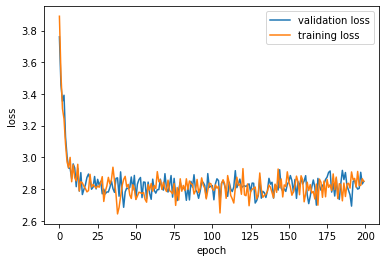

In [6]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()